In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn.functional as F
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm_notebook, tnrange
import scipy.signal
import pdb

%config IPCompleter.greedy=True
%config InlineBackend.figure_format='retina'

In [5]:
# # load training set
# Raman_chunk_train = pd.read_csv('./data/raman_data/Raman_spectrums_train_2.csv')
# CARS_chunk_train = pd.read_csv('./data/raman_data/CARS_spectrums_train_2.csv')

# # load validation set
# Raman_chunk_valid = pd.read_csv('./data/raman_data/Raman_spectrums_valid_2.csv')
# CARS_chunk_valid = pd.read_csv('./data/raman_data/CARS_spectrums_valid_2.csv')


# load training set
Raman_chunk_train = pd.read_csv('./data/Raman_spectrums_train.csv')
CARS_chunk_train = pd.read_csv('./data/CARS_spectrums_train.csv')

# load validation set
Raman_chunk_valid = pd.read_csv('./data/Raman_spectrums_valid.csv')
CARS_chunk_valid = pd.read_csv('./data/CARS_spectrums_valid.csv')


# normalize the data
Raman_chunk_train = Raman_chunk_train.values[:,1:]/np.tile(Raman_chunk_train.values[:,1:].max(axis=1, keepdims=True), 1000)
CARS_chunk_train = CARS_chunk_train.values[:,1:]/np.tile(CARS_chunk_train.values[:,1:].max(axis=1, keepdims=True), 1000)
Raman_chunk_valid = Raman_chunk_valid.values[:,1:]/np.tile(Raman_chunk_valid.values[:,1:].max(axis=1, keepdims=True), 1000)
CARS_chunk_valid = CARS_chunk_valid.values[:,1:]/np.tile(CARS_chunk_valid.values[:,1:].max(axis=1, keepdims=True), 1000)

In [6]:
# construct autoencoder
class autoencoder(nn.Module):
    def __init__(self, n_fc1, n_fc2, n_fc3, n_fc4, n_fc5):
        super(autoencoder, self).__init__()
        self.n_fc1_en = n_fc1
        self.n_fc2_en = n_fc2
        self.n_fc3_en = n_fc3
        self.n_fc4_en = n_fc4
        self.n_fc5_en = n_fc5
        
        
        self.n_fc1_de = n_fc5
        self.n_fc2_de = n_fc4
        self.n_fc3_de = n_fc3
        self.n_fc4_de = n_fc2
        self.n_fc5_de = n_fc1
        
        self.encoder = nn.Sequential(
            nn.Linear(self.n_fc1_en, self.n_fc2_en),
            nn.BatchNorm1d(self.n_fc2_en),
#             nn.ReLU(True),
            nn.Sigmoid(),
            nn.Linear(self.n_fc2_en, self.n_fc3_en),
            nn.BatchNorm1d(self.n_fc3_en),
#             nn.ReLU(True),
            nn.Sigmoid(),
            nn.Linear(self.n_fc3_en, self.n_fc4_en),
            nn.BatchNorm1d(self.n_fc4_en),
#             nn.ReLU(True),
            nn.Sigmoid(),
            nn.Linear(self.n_fc4_en, self.n_fc5_en),
            nn.BatchNorm1d(self.n_fc5_en),
#             nn.ReLU(True),
            nn.Sigmoid(),
#             nn.Linear(2000, 1000),
#             nn.ReLU(True),
#             nn.Linear(1000, 500)
)
        self.decoder = nn.Sequential(
#             nn.Linear(500, 1000),
#             nn.ReLU(True),
#             nn.Linear(1000, 2000),
#             nn.ReLU(True),
            nn.Linear(self.n_fc1_de, self.n_fc2_de),
            nn.BatchNorm1d(self.n_fc2_de),
#             nn.ReLU(True),
            nn.Sigmoid(),
            nn.Linear(self.n_fc2_de, self.n_fc3_de), 
            nn.BatchNorm1d(self.n_fc3_de),
#             nn.ReLU(True),
            nn.Sigmoid(),
            nn.Linear(self.n_fc3_de, self.n_fc4_de), 
            nn.BatchNorm1d(self.n_fc4_de),
#             nn.ReLU(True),
            nn.Sigmoid(),
            nn.Linear(self.n_fc4_de, self.n_fc5_de),
            nn.BatchNorm1d(self.n_fc5_de),
            nn.Sigmoid(),
)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def get_neurons(self, x): # get all activation neurons of the model
        a_L1_en = self.encoder[:3](x)
        a_L2_en = self.encoder[:6](x)
        a_L3_en = self.encoder[:9](x)

        latents = self.encoder[:12](x)

        a_L1_de = self.decoder[:3](latents)
        a_L2_de = self.decoder[:6](latents)
        a_L3_de = self.decoder[:9](latents)

        hidden_activations = torch.cat([a_L1_en, a_L2_en, a_L3_en, latents, a_L1_de, a_L2_de, a_L3_de], axis=1)
        return hidden_activations
    
def loss_function(recon_x, x, rau_i, rau, beta): #hidden_neurons_batch: [samples, number of neurons]
    BCE = F.mse_loss(recon_x.view(-1, 1000), x.view(-1, 1000))
    sparse_loss = torch.sum(rau*torch.log(rau/rau_i)+(1-rau)*torch.log((1-rau)/(1-rau_i))) 
    return BCE, beta*sparse_loss
#     return BCE, torch.max(sparse_loss, torch.Tensor([0.002]).float().cuda())
#     return BCE

# input is array
# def calculate_raui(x_array, batch_size):
#     batch_num = int(x_array.shape[0]/batch_size) 
#     raui = []
#     for batch_i in range(batch_num):
#         x = x_array[int(batch_i*batch_num):int(batch_i*batch_num+batch_size),:]
#         x = torch.from_numpy(x).float().cuda()
#         hidden_neurons_batch = model.get_neurons(x)
#         raui.append(hidden_neurons_batch)
#     if x_array.shape[0] % batch_size:
#         x = x_array[::-1][0:(x_array.shape[0] % batch_size),:][::-1]
#         x = torch.from_numpy(x).float().cuda()
#         hidden_neurons_batch = model.get_neurons(x)
#         raui.append(hidden_neurons_batch)        
#     raui = torch.cat(raui)
#     return raui.mean(axis=0)


# Sparse factor
def calculate_raui(x_tensor, batch_size):
    batch_num = int(list(x_tensor.shape)[0]/batch_size) 
    raui = []
    for batch_i in range(batch_num):
        x = x_tensor[int(batch_i*batch_num):int(batch_i*batch_num+batch_size),:]
        hidden_neurons_batch = model.get_neurons(x)
        raui.append(hidden_neurons_batch)
    if list(x_tensor.shape)[0] % batch_size:
        x = x_tensor[int(x_tensor.shape[0] - x_tensor.shape[0] % batch_size):, :]
#         x = x_tensor[::-1][0:(list(x_tensor.shape)[0] % batch_size),:][::-1]
        hidden_neurons_batch = model.get_neurons(x)
        raui.append(hidden_neurons_batch)        
    raui = torch.cat(raui)
    return raui.mean(axis=0)



# check raui's shape
# calculate_raui(cars_train, batch_size).shape

# check KL 
# rau = 0.2
# rau_i = np.linspace(0, 1, 1000)
# D_kl = rau*np.log(rau/rau_i)+(1-rau)*np.log((1-rau)/(1-rau_i))
# plt.plot(rau_i, D_kl)

In [7]:
# define model function
model = autoencoder(n_fc1=1000, n_fc2=800, n_fc3=600, n_fc4=400, n_fc5=200)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
#model = nn.DataParallel(model,device_ids=[0,1])
model.to('cuda:0')

# criterion = nn.MSELoss()

# weight_decay=1e-5
print(model)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=1000, out_features=800, bias=True)
    (1): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
    (3): Linear(in_features=800, out_features=600, bias=True)
    (4): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Sigmoid()
    (6): Linear(in_features=600, out_features=400, bias=True)
    (7): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Sigmoid()
    (9): Linear(in_features=400, out_features=200, bias=True)
    (10): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=200, out_features=400, bias=True)
    (1): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
    (3): Linear(in_features=400, out_features=600, bias=True)
    (4): Batc

In [8]:
# training
epoch_num = 400
batch_size = 256
batch_num = int(Raman_chunk_train.shape[0]/batch_size)

training_BCE_plot = []

step_ = 0
rau = 0.5
beta = 0  

raman_train = torch.from_numpy(Raman_chunk_train).float().to('cuda:0')
cars_train = torch.from_numpy(CARS_chunk_train).float().to('cuda:0')

raman_valid = torch.from_numpy(Raman_chunk_valid).float().to('cuda:0')
cars_valid = torch.from_numpy(CARS_chunk_valid).float().to('cuda:0')
for epoch in tnrange(epoch_num):
    for batch_i in range(batch_num):
        model.train()
#         raman_train = Raman_chunk_train[int(batch_i*batch_size):int(batch_i*batch_size+batch_size),:]
#         cars_train = CARS_chunk_train[int(batch_i*batch_size):int(batch_i*batch_size+batch_size),:]
#         raman_train_tensor = torch.from_numpy(raman_train).float().cuda()
#         cars_train_tensor = torch.from_numpy(cars_train).float().cuda()

        raman_train_tensor = raman_train[int(batch_i*batch_size):int(batch_i*batch_size+batch_size),:]
        cars_train_tensor = cars_train[int(batch_i*batch_size):int(batch_i*batch_size+batch_size),:]
        
        optimizer.zero_grad()
        outputs = model(raman_train_tensor)
#         loss = criterion(outputs, raman_train_tensor)
    
#         rau_i = calculate_raui(CARS_chunk_train, batch_size)
#         rau_i = calculate_raui(raman_train, batch_size)
    
        BCE, sparse_loss = loss_function(outputs, raman_train_tensor, torch.Tensor([.5]), rau, beta)
        loss = BCE + sparse_loss
#         loss = BCE
        loss.backward()
        optimizer.step()
        training_BCE_plot.append(BCE.cpu().detach().numpy().item())
        
        if step_ % 100 == 0:
            valid_loss = []
            BCEs_valid = []
            sparse_losses_valid = []
            model.eval()
            for valid_i in range(int(Raman_chunk_valid.shape[0]/batch_size)):
#                 raman_valid = Raman_chunk_valid[int(valid_i*batch_size):int(valid_i*batch_size+batch_size),:]
#                 cars_valid = CARS_chunk_valid[int(valid_i*batch_size):int(valid_i*batch_size+batch_size),:]
#                 raman_valid_tensor = torch.from_numpy(raman_valid).float().cuda()
#                 cars_valid_tensor = torch.from_numpy(cars_valid).float().cuda() 
                raman_valid_tensor = raman_valid[int(valid_i*batch_size):int(valid_i*batch_size+batch_size),:]
                cars_valid_tensor = cars_valid[int(valid_i*batch_size):int(valid_i*batch_size+batch_size),:]
                outputs = model(raman_valid_tensor)
#                 loss_valid = criterion(outputs, raman_valid_tensor)

#                 rau_i_valid = calculate_raui(CARS_chunk_valid, batch_size) # input is array
#                 rau_i_valid = calculate_raui(raman_valid, batch_size) # input is tensor
                BCE_valid, sparse_loss_valid = loss_function(outputs, raman_valid_tensor, torch.Tensor([.5]), rau, beta)
                loss_valid = BCE_valid.clone()
                valid_loss.append(loss_valid.item())
                BCEs_valid.append(BCE_valid.item())
                sparse_losses_valid.append(sparse_loss_valid.item())
            print('step: {}, training loss: {}[{}/{}], valid loss: {}[{}/{}]'.format(
                                                             step_, 
                                                             loss.item(),
                                                             BCE.item(),
                                                             sparse_loss.item(),
                                                             np.mean(valid_loss),
                                                             np.mean(BCEs_valid),
                                                             np.mean(sparse_losses_valid)
                                                             ))
        step_ += 1

step: 0, training loss: 0.09531231224536896[0.09531231224536896/0.0], valid loss: 0.05667047439651056[0.05667047439651056/0.0]
step: 100, training loss: 0.061920251697301865[0.061920251697301865/0.0], valid loss: 0.07420934939926321[0.07420934939926321/0.0]
step: 200, training loss: 0.052814263850450516[0.052814263850450516/0.0], valid loss: 0.111608279699629[0.111608279699629/0.0]
step: 300, training loss: 0.04400049149990082[0.04400049149990082/0.0], valid loss: 0.06228118593042547[0.06228118593042547/0.0]
step: 400, training loss: 0.039818719029426575[0.039818719029426575/0.0], valid loss: 0.10047623311931436[0.10047623311931436/0.0]
step: 500, training loss: 0.03532922640442848[0.03532922640442848/0.0], valid loss: 0.03300510228357532[0.03300510228357532/0.0]
step: 600, training loss: 0.03337441384792328[0.03337441384792328/0.0], valid loss: 0.03804249655116688[0.03804249655116688/0.0]
step: 700, training loss: 0.0320296473801136[0.0320296473801136/0.0], valid loss: 0.0381656387312

step: 6100, training loss: 0.0004238446999806911[0.0004238446999806911/0.0], valid loss: 0.0004734294356735931[0.0004734294356735931/0.0]
step: 6200, training loss: 0.0004044606175739318[0.0004044606175739318/0.0], valid loss: 0.0004373539493165233[0.0004373539493165233/0.0]
step: 6300, training loss: 0.00037043855991214514[0.00037043855991214514/0.0], valid loss: 0.00041509761252779174[0.00041509761252779174/0.0]
step: 6400, training loss: 0.0003980586479883641[0.0003980586479883641/0.0], valid loss: 0.00035771046796898275[0.00035771046796898275/0.0]
step: 6500, training loss: 0.0003484163316898048[0.0003484163316898048/0.0], valid loss: 0.00039341344117102295[0.00039341344117102295/0.0]
step: 6600, training loss: 0.0003116365405730903[0.0003116365405730903/0.0], valid loss: 0.00032492535485124046[0.00032492535485124046/0.0]
step: 6700, training loss: 0.000328869151417166[0.000328869151417166/0.0], valid loss: 0.00031210665210065514[0.00031210665210065514/0.0]
step: 6800, training los

step: 11900, training loss: 2.102154576277826e-05[2.102154576277826e-05/0.0], valid loss: 0.00010938019311817533[0.00010938019311817533/0.0]
step: 12000, training loss: 2.7087717171525583e-05[2.7087717171525583e-05/0.0], valid loss: 5.8847619088324294e-05[5.8847619088324294e-05/0.0]


KeyboardInterrupt: 

In [9]:
# set model to evluating mode. It is important to switch model from train() to eval() when doting testing !!!!!!
model.eval()

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=1000, out_features=800, bias=True)
    (1): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
    (3): Linear(in_features=800, out_features=600, bias=True)
    (4): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Sigmoid()
    (6): Linear(in_features=600, out_features=400, bias=True)
    (7): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Sigmoid()
    (9): Linear(in_features=400, out_features=200, bias=True)
    (10): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=200, out_features=400, bias=True)
    (1): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
    (3): Linear(in_features=400, out_features=600, bias=True)
    (4): Batc

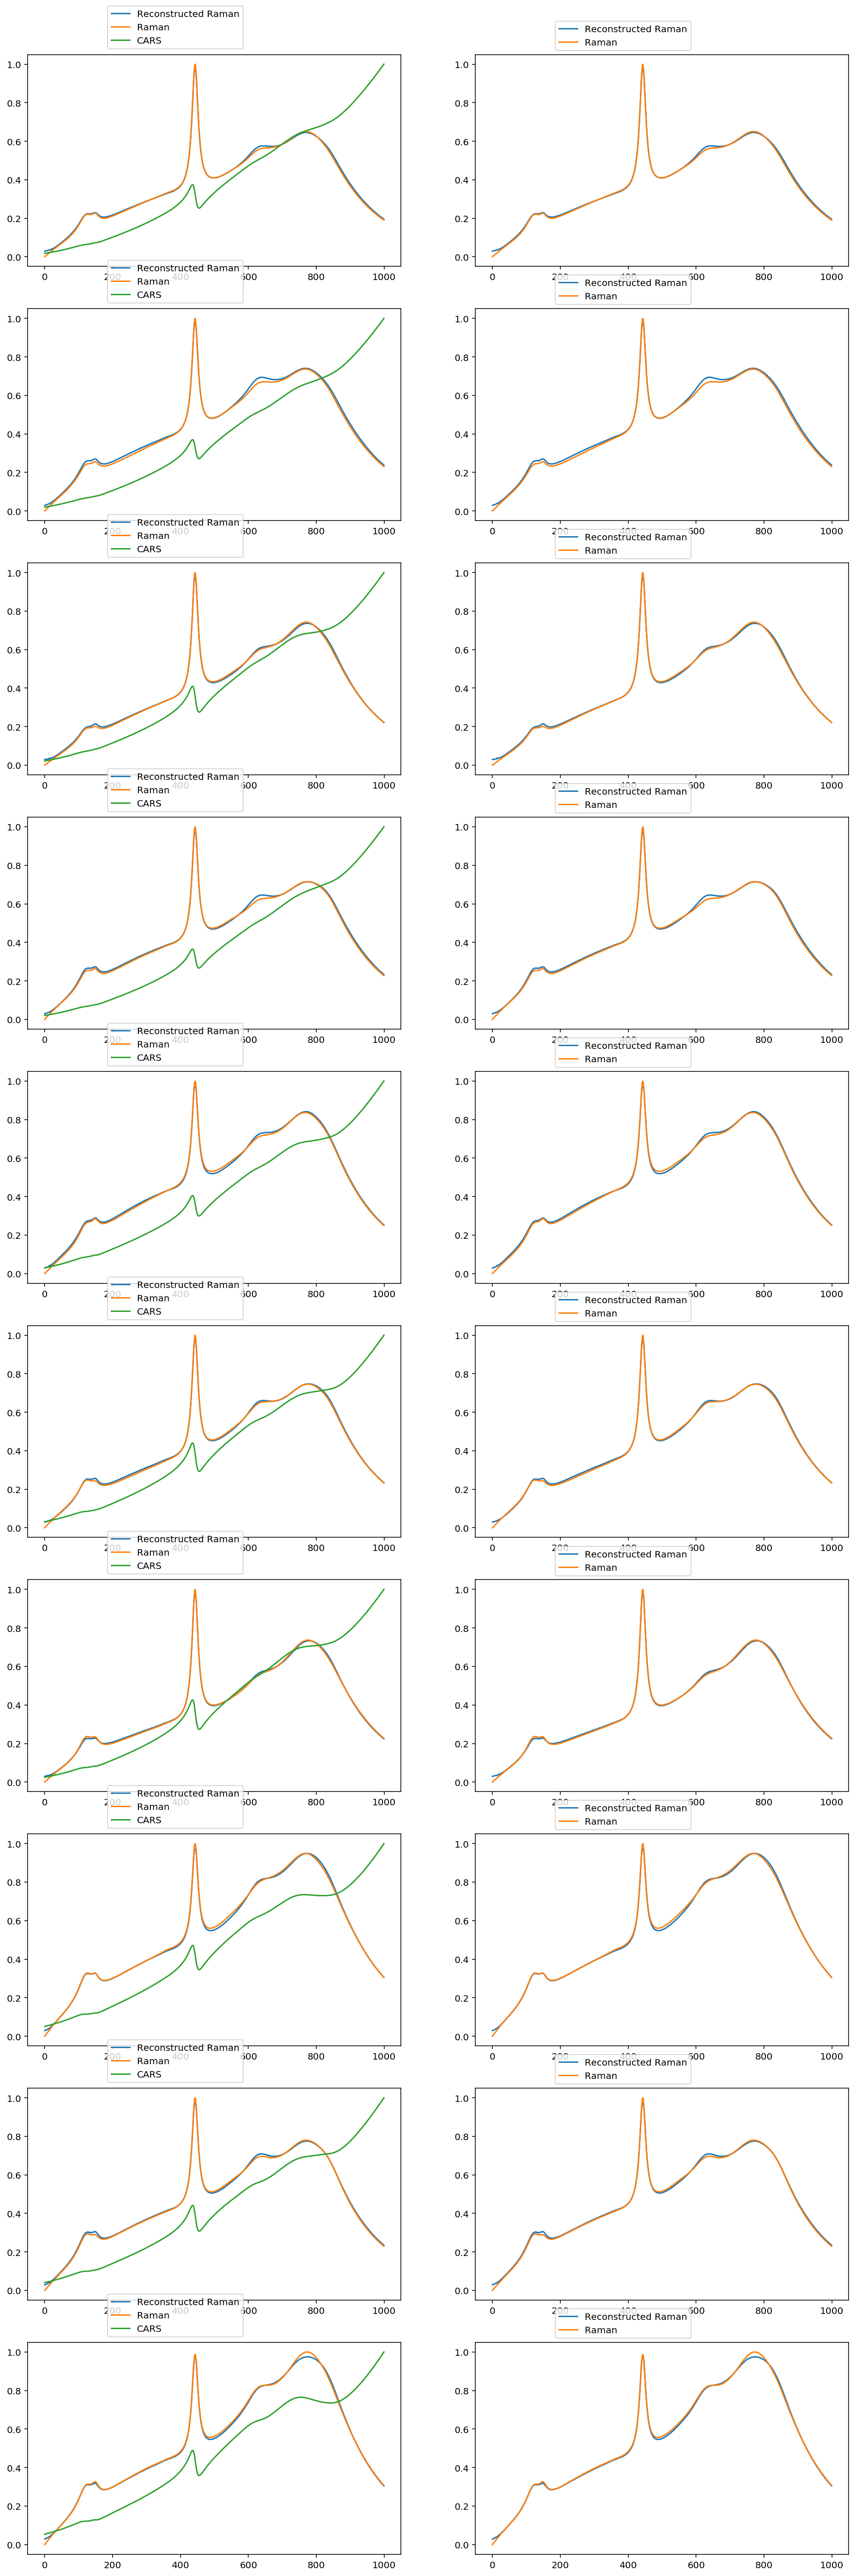

In [11]:
plt.figure(figsize=(16,50))
model.eval()
i = 0
for ind in range(10, 20):
    outputs = model(raman_valid_tensor[ind:(ind+1),...])
    plt.subplot(10,2,i*2+1)
    plt.plot(outputs.detach().cpu().numpy()[0])
    plt.plot(raman_valid_tensor[ind].detach().cpu().numpy())
    plt.plot(cars_valid_tensor[ind].detach().cpu().numpy())
    plt.legend(['Reconstructed Raman', 'Raman', 'CARS'], bbox_to_anchor=(0.09, 0.75, 0.5, 0.5))


    plt.subplot(10,2,i*2+2)
    plt.plot(outputs.detach().cpu().numpy()[0])
    plt.plot(raman_valid_tensor[ind].detach().cpu().numpy())
    plt.legend(['Reconstructed Raman', 'Raman'], bbox_to_anchor=(0.09, 0.68, 0.5, 0.5))


    # neurons = calculate_raui(CARS_chunk_valid, 1)
#     neurons = calculate_raui(raman_valid[ind:(ind+1),...], 1)
#     neurons = neurons.detach().cpu().numpy()
#     plt.subplot(10,3,i*3+3)
#     fig = plt.hist(neurons,bins=50)
#     title=plt.title('Hidden neurons distribution')
    i += 1

In [ ]:
neurons = calculate_raui(cars_train[ind:(ind+1),...], 1)
neurons = neurons.detach().cpu().numpy()
plt.figure()
fig = plt.hist(neurons,bins=50)